In [1]:
import os
import torch
from thexp import globs,Meter

from trainers import GlobalParams
from data.collate_fns import convert_batch_sparse_matrix_collate_fn
from data.delegate import ASGLoadDelegate
from data.dataxy import mscoco

In [3]:
from trainers.asg2cap import BaseTrainer

In [4]:
params = GlobalParams()
params.greedy_or_beam = True
trainer = BaseTrainer(params)

add output channel on /home/yanghaozhe/.thexp/experiments/asg2cap.e0/asg2cap.baseExp/0003.b64ec0af/l.210312180703.0.log
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py -f /home/yanghaozhe/.local/share/jupyter/runtime/kernel-5cfda46f-4415-4742-b476-b34beee45749.json | 
21-03-12 18:07:03 | Exp BaseDir | /home/yanghaozhe/.thexp/experiments/asg2cap.e0/asg2cap.baseExp
21-03-12 18:07:03 | Exp Trainer | BaseTrainer
21-03-12 18:07:03 | Exp Params
GlobalParams[('epoch', 100),
 ('eidx', 1),
 ('idx', 0),
 ('global_step', 0),
 ('device', 'cuda:0'),
 ('device_ids', []),
 ('dataset', 'mscoco'),
 ('architecture', 'rgcn.flow.memory'),
 ('optim',
  OptimParams([('args', attr([('lr', 0.0002), ('weight_decay', 0)])),
               ('name', 'Adam')])),
 ('git_commit', True),
 ('tmp_dir', None),
 ('distributed', False),
 ('world_size', -1),
 ('local_rank', -1),
 ('init_method', 'env://'),
 ('attn_encoder', 'role_rgcn'),
 ('decoder', 'memory_flow'),
 ('n_classes', 10),
 ('topk', (1, 2, 3, 4)),

In [6]:
# load pretrained model

# root path to pretrained model
model_root = '...'
model_pt = os.path.join(model_root,'keep.0000030.ckpt')
trainer.load_checkpoint(model_pt)

In [7]:
# root path to your coco2014 dataset location
cocoimg_root = '.../COCO/2014/'

# root path to your asg dataset location provided in https://github.com/cshizhe/asg2cap
asg_coco_root = 'asg2cap/ControllableImageCaption/MSCOCO'

In [8]:
datas =mscoco('test',set_root=asg_coco_root)

In [9]:
region_ids, json_fs, hdf5_fs, mp_ids, mp_fts = datas

In [10]:
json_fn = json_fs[2].strip('.json')
img_path = os.path.join(cocoimg_root,'{}.jpg'.format('/'.join(json_fn.split('/')[-2:])))

In [13]:
print(os.path.abspath(img_path))

/home/yanghaozhe/python/thexp-implement/asg2cap/asg2cap/.../COCO/2014/val2014/COCO_val2014_000000452113.jpg


# Inference

In [18]:
self = trainer
batch = trainer.test_dataloader.choice_batch()
batch_data = batch

from thexp import Meter
from data.transforms import Int2Sent

meter = Meter()
int2sent_func = Int2Sent()


if params.greedy_or_beam:
    from thextra.inferences import sample_decode as decode_func
else:
    # not implemented
    from thextra.inferences import beam_search_decode as decode_func

enc_outs = self.model.encode(batch_data=batch_data)  # type:dict
init_words = torch.zeros(batch_data['attn_masks'].size(0), dtype=torch.int64).to(self.device)

states = []
for _ in range(2):  # (hidden, cell)
    states.append(torch.zeros((2, params.batch_size, self.params.hidden_size),
                              dtype=torch.float32).to(self.device))

_, max_attn_len = batch_data['attn_masks'].shape
prev_attn_score = torch.zeros((params.batch_size, max_attn_len), device=self.device)
prev_attn_score[:, 0] = 1

enc_globals = enc_outs['init_states']
enc_memories = enc_outs['attn_fts']
enc_masks = batch_data['attn_masks']
flow_edges = batch_data['flow_edges']

result = decode_func(init_words, self.model.decoder.step_fn, params.max_words_in_sent,
                     greedy=True, states=states, enc_globals=enc_globals,
                     enc_memories=enc_memories, memory_masks=enc_masks,
                     prev_attn_score=prev_attn_score, flow_edges=flow_edges)

if params.greedy_or_beam:
    pred_sent, word_logprobs = result
    sent_pool = []
    for sent, word_logprob in zip(pred_sent, word_logprobs):
        sent_pool.append([(word_logprob.sum().item(), sent, word_logprob)])
else:
    sent_pool = result
    pred_sent = [pool[0][1] for pool in sent]

word_sents = []
gt_sents = []
for i, sent, gt_sent in zip(batch_data['index'], pred_sent, batch_data['caption_ids']):
    sent = sent.detach().cpu().numpy().tolist()
    gt_sent = gt_sent.detach().cpu().numpy().tolist()

    sent = int2sent_func(sent)
    gt_sent = int2sent_func(gt_sent)
    gt_sents.append(gt_sent)
    word_sents.append(sent)

gt_sents = {i: [v] for i, v in enumerate(gt_sents)}
word_sents = {i: [v] for i, v in enumerate(word_sents)}

self.acc_bleu_(gt_sents, word_sents, meter=meter)
self.acc_cider_(gt_sents, word_sents, meter=meter)

(1.7238018162070041,
 array([6.83237863e-01, 3.18185131e+00, 5.17484718e-02, 7.13428363e+00,
        8.33883776e-01, 3.05561714e-01, 4.62660104e-01, 7.86409468e-02,
        2.80662551e+00, 9.43192422e-01, 1.15172792e+00, 8.87019579e-01,
        0.00000000e+00, 1.65409347e-01, 4.75902650e-01, 9.19417308e-01,
        7.47406924e-01, 3.82002369e-01, 2.71265771e-01, 1.40136456e-01,
        2.40561105e-01, 1.31271006e-01, 3.03626584e-02, 3.21047357e+00,
        5.20694049e-01, 1.68328223e+00, 2.33831933e+00, 6.38795028e-04,
        1.19781988e-03, 7.23874857e-01, 4.48683638e-04, 1.64965453e-03,
        1.25503996e+00, 8.20668839e-01, 1.57341928e+00, 3.39825254e+00,
        6.10603517e-01, 2.25603177e+00, 4.41351208e+00, 6.15252939e+00,
        5.55018932e+00, 3.39923842e-01, 1.68002735e+00, 9.54076207e+00,
        4.66242914e+00, 1.78375771e+00, 3.59560486e-01, 4.01594241e-02,
        2.49685251e+00, 8.84389414e-01, 1.87855989e+00, 1.18551076e+00,
        1.95290753e-01, 2.11314051e+00, 1.7

In [68]:
batch.keys()

dict_keys(['index', 'region_ids', 'mp_fts', 'attn_fts', 'attn_masks', 'node_types', 'attr_order_idxs', 'caption_ids', 'caption_masks', 'flow_edges', 'rel_edges'])

In [75]:
batch['flow_edges'][2].sum()

tensor(7., device='cuda:0')

In [19]:
from matplotlib import pyplot as plt

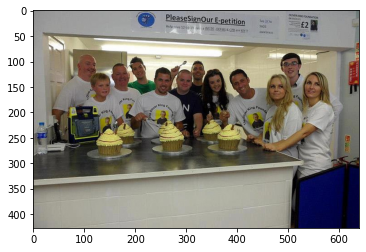

In [20]:
plt.imshow(plt.imread(img_path))

In [21]:
gt_sents[2]

['<BOS> a counter of cakes surrounded by a group of people']

In [22]:
word_sents[2]

['a table with a cake sitting on top of a wall in a room']

In [76]:
sample = trainer.test_dataloader.dataloaders['unnamed_0'][0].dataset[0]

In [77]:
sample['mp_fts'].shape

(2048,)

In [40]:
sample.keys()

odict_keys(['index', 'region_ids', 'mp_fts', 'attn_fts', 'attn_masks', 'node_types', 'attr_order_idxs', 'edge_sparse_matrices', 'flow_sparse_matrix', 'caption_ids', 'caption_masks', '_ipython_canary_method_should_not_exist_'])

In [57]:
# 所有 node 的特征，object 的特征是 box 特征，attr 特征和 obj 相同，rel 特征和两个obj 的外接 box 特征相同，每个node 的特征是 2048 dim
# 添加特征完成后，进行 pad 和 cut
sample['attn_fts'].shape

(10, 2048)

In [78]:
# 表示哪些 feature 是 node 的特征
print(sample['attn_masks'])
# 表明结点类型 0，1，2 分别为 o a r，和 attn_fts 长度相同
print(sample['node_types'])

print(sample['attr_order_idxs'])
print(sample['edge_sparse_matrices'])
print(sample['flow_sparse_matrix'])
print(sample['attn_masks'])
print(sample['caption_ids'])
print(sample['caption_masks'])


array([ True,  True,  True,  True,  True,  True,  True,  True, False,
       False])